# ⚽ YOLOv8 Fine-tuning for Football Ball + Player Detection
This notebook fine-tunes a YOLOv8 model to detect:
- **Players**
- **Goalkeepers**
- **Referees**
- **Ball** 🟠 (main focus)

We’ll:
1. Set up the Colab environment
2. Upload or mount the dataset
3. Inspect class balance
4. Oversample or augment ball images
5. Fine-tune YOLOv8
6. Evaluate and visualize results
7. Save and download the trained model for local use


In [1]:
# Install dependencies
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 ultralytics -U
!pip install -q opencv-python-headless matplotlib albumentations

# Imports
import os
from pathlib import Path
import yaml
import random
import shutil
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

print("✅ Environment ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 137.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path (EDIT THIS to match your Drive folder)
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/data')


assert DATA_DIR.exists(), f"{DATA_DIR} not found, please adjust the path."
print("📁 Dataset directory:", DATA_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Dataset directory: /content/drive/MyDrive/Colab Notebooks/data


## Step 1 — Check Dataset Structure and Class Counts
We’ll count how many labels each class has to detect imbalance (especially the ball class).

In [3]:
class_names = ['ball', 'goalkeeper', 'player', 'referee']  # update if different

def count_labels(label_dir):
    counts = [0] * len(class_names)
    label_files = list(Path(label_dir).glob('**/*.txt'))
    for lf in label_files:
        with open(lf, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                cls = int(line.split()[0])
                if cls < len(counts):
                    counts[cls] += 1
    return counts, len(label_files)

train_labels = DATA_DIR / 'train' / 'labels'
val_labels = DATA_DIR / 'valid' / 'labels'
test_labels = DATA_DIR / 'test' / 'labels'

train_counts, n_train_label_files = count_labels(train_labels)
val_counts, n_val_label_files = count_labels(val_labels)
test_counts, n_test_label_files = count_labels(test_labels)

print("Train image files:", n_train_label_files)
print("Train object counts per class:", dict(zip(class_names, train_counts)))
print("Val object counts per class:", dict(zip(class_names, val_counts)))
print("Test object counts per class:", dict(zip(class_names, test_counts)))


Train image files: 1644
Train object counts per class: {'ball': 1557, 'goalkeeper': 1173, 'player': 32850, 'referee': 3783}
Val object counts per class: {'ball': 35, 'goalkeeper': 27, 'player': 754, 'referee': 89}
Test object counts per class: {'ball': 11, 'goalkeeper': 11, 'player': 259, 'referee': 29}


## Step 2 — Create a New `data.yaml`
We’ll point training to the oversampled folder.


In [4]:
# Build a new data.yaml pointing to train_oversampled (if created) or original train
data_yaml = {
    'names': class_names,
    'nc': len(class_names),
    'train': str(DATA_DIR / 'train' / 'images'),
    'val': str(DATA_DIR / 'valid' / 'images'),
    'test': str(DATA_DIR / 'test' / 'images'),
}
yaml_path = DATA_DIR / 'data_balanced.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)
print("Wrote", yaml_path)
print(open(yaml_path).read())


Wrote /content/drive/MyDrive/Colab Notebooks/data/data_balanced.yaml
names:
- ball
- goalkeeper
- player
- referee
nc: 4
test: /content/drive/MyDrive/Colab Notebooks/data/test/images
train: /content/drive/MyDrive/Colab Notebooks/data/train/images
val: /content/drive/MyDrive/Colab Notebooks/data/valid/images



## Step 3 — Fine-tune YOLOv8
We’ll use a pretrained model.

We’ll train with:
- Higher image size (1024) to detect small balls better
- MixUp, Mosaic augmentations (default)
- Early stopping and checkpoint saving


In [5]:
from ultralytics import YOLO
model = YOLO('../yolov8m.pt')

# training hyperparams
train_data_yaml = str(yaml_path)
imgsz = 1024                # higher resolution helps for small balls.
epochs = 80                 # increase if underfitting
batch = 8                   # reduce if you run out of GPU memory
device_to_use = 0           # if Colab GPU available, set 0. Otherwise 'cpu' or the device string you prefer

print("Training with:", model, train_data_yaml, "imgsz", imgsz)

# For emphasis on ball & players: use augment=True, and use a lower lr warmup then reduce
model.train(
    data=train_data_yaml,
    epochs=epochs,
    imgsz=imgsz,
    batch=batch,
    device=device_to_use,
    workers=4,
    optimizer="SGD",
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    augment=True,   # includes mosaic and mixup
    patience=30,    # early stopping patience
    save=True
)

Training with: YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x792cf8108260>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Step 3 — Evaluate and Visualize Results
We’ll use the best weights found in the training run (Ultralytics automatically saves it).


In [6]:
from pathlib import Path

best_weights = sorted(Path('../runs').glob('**/weights/best.pt'))[-1]
print("🏆 Best model saved at:", best_weights)

model = YOLO(best_weights)
results = model.val()
print(results)


🏆 Best model saved at: runs/detect/train/weights/best.pt
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 90.1±10.6 MB/s, size: 217.2 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/data/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 38/38 74.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.5it/s 6.4s
                   all         38        905      0.906      0.836      0.889      0.677
                  ball         35         35      0.892      0.472       0.62      0.316
            goalkeeper         27         27      0.836      0.926      0.966      0.806
                player         38        754      0.962      0.981       0.99      0.853
               referee         38         89      0.935    

## Step 5 — Save and Download the Model for Local Use


In [7]:
from google.colab import files

# Find and download the best model
best_model_path = sorted(Path('../runs').glob('**/weights/best.pt'))[-1]
print("Downloading:", best_model_path)
files.download(best_model_path)


Downloading: runs/detect/train/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 6 — Visualize Predictions
Let’s look at some example detections from the validation set.



image 1/1 /content/drive/MyDrive/Colab Notebooks/data/valid/images/4b770a_3_1_png.rf.4715dcbc4be0f14fbb5d8450fcff5bf0.jpg: 576x1024 1 ball, 2 goalkeepers, 21 players, 2 referees, 46.5ms
Speed: 5.2ms preprocess, 46.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


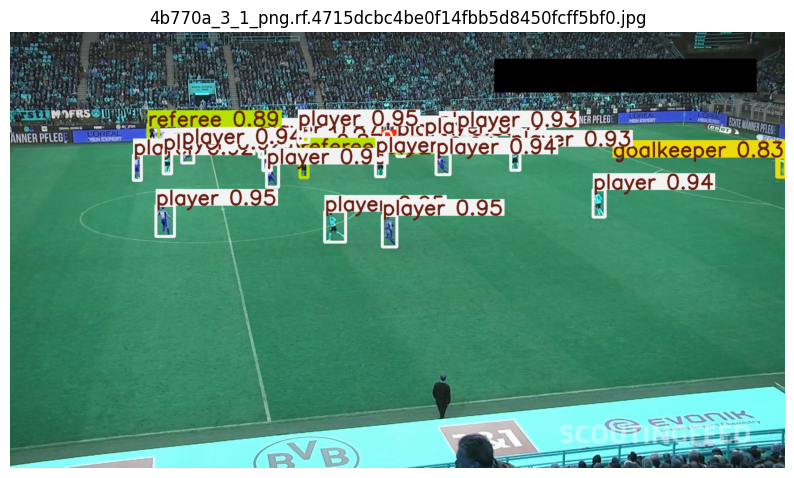


image 1/1 /content/drive/MyDrive/Colab Notebooks/data/valid/images/4b770a_3_7_png.rf.0fe6dc6c1fd85518ff5456a914a7571d.jpg: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 39.5ms
Speed: 6.7ms preprocess, 39.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


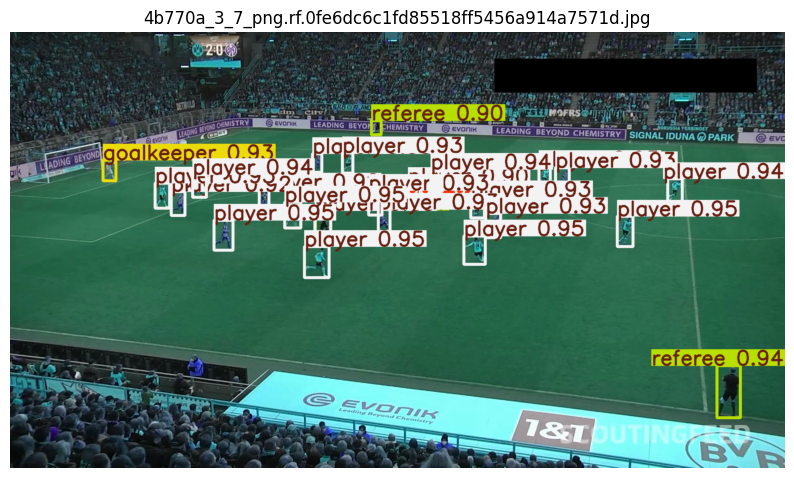


image 1/1 /content/drive/MyDrive/Colab Notebooks/data/valid/images/42ba34_1_4_png.rf.0190fbc779b7f4320c25835a5d952de0.jpg: 576x1024 2 goalkeepers, 20 players, 3 referees, 39.5ms
Speed: 6.7ms preprocess, 39.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)


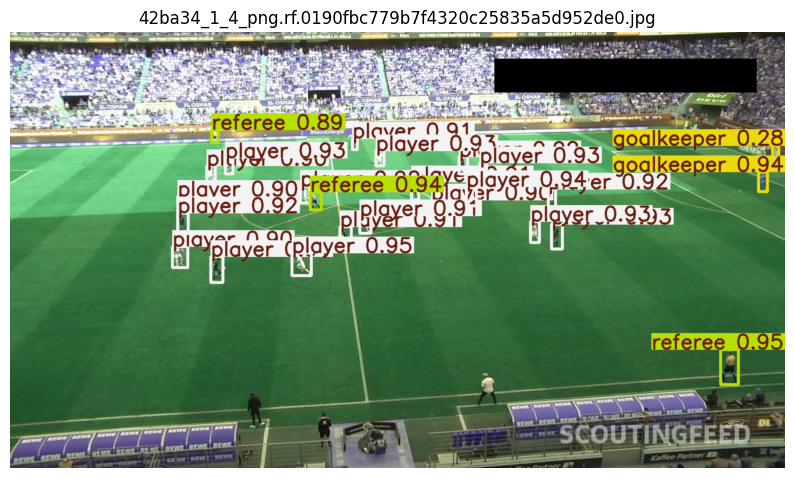


image 1/1 /content/drive/MyDrive/Colab Notebooks/data/valid/images/538438_1_5_png.rf.927cf8101773ba75712dcee17a35e56b.jpg: 576x1024 1 goalkeeper, 18 players, 3 referees, 39.5ms
Speed: 6.7ms preprocess, 39.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


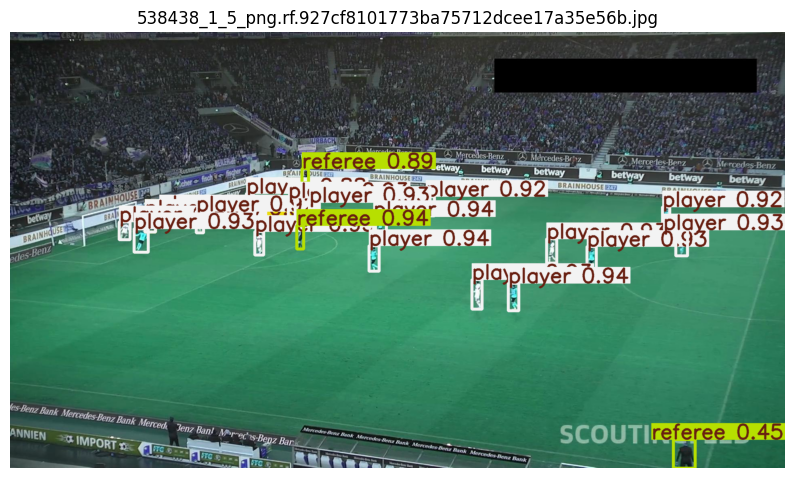


image 1/1 /content/drive/MyDrive/Colab Notebooks/data/valid/images/538438_9_8_png.rf.f77a8d26e22089ac66e5c925a6d52d70.jpg: 576x1024 1 goalkeeper, 20 players, 3 referees, 39.5ms
Speed: 6.9ms preprocess, 39.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


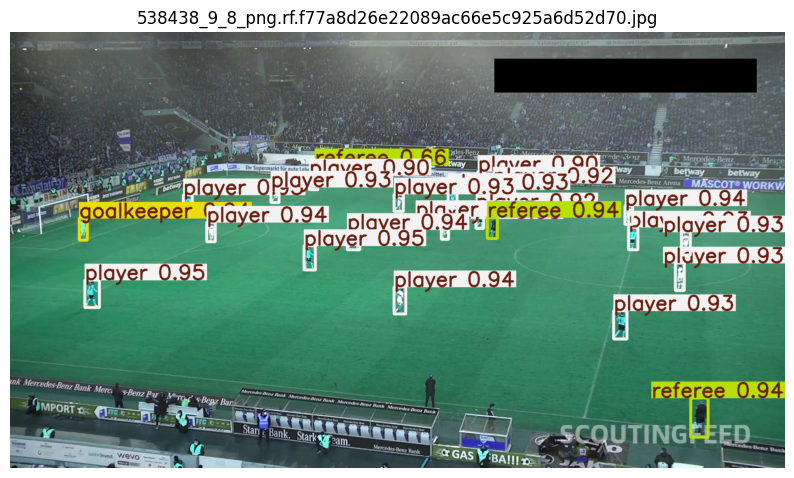

In [8]:
import random
val_images = list((DATA_DIR / 'valid' / 'images').glob('*'))
samples = random.sample(val_images, min(5, len(val_images)))

for img_path in samples:
    res = model.predict(source=str(img_path), conf=0.25)
    im = res[0].plot()
    plt.figure(figsize=(10,6))
    plt.imshow(im)
    plt.axis('off')
    plt.title(img_path.name)
    plt.show()
